## 참고

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### dataset

 label    |     images <br>
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ <br>
 졸음     |     a1, a2, a3 ....<br>
 졸음     |     b1, b2, b3 ....

# 1. Train data 만들기

1. 현재 데이터 구조
    - drowsy, non drowy 폴더에 약 20명의 졸음, 정상 이미지가 serial 순으로 저장되어있음.

2. 각 사람 별 이미지 개수 확인
    - 개수가 천차 만별이라 600장(600frame)이상 있는 사람을 선별.
    

3. 시계열 이미지 파일이기 때문에 ConvLSTM2D 사용
    - (샘플개수, 타임스텝, H, W, 채널)의 차원으로 input data를 생성해야함.
    - 라벨을 같이 튜플로 묶어 fit_generator에 넣거나
    - 라벨을 따로 만들어 fit에 넣는다
    

### 1 - 1. 수집 데이터 파악

#### image 폴더명 (label)

In [1]:
import os
from glob import glob

target_class = os.listdir('../Data/Driver Drowsiness Dataset (DDD)/Original_dataset/')
print(target_class)

['Drowsy', 'Non Drowsy']


#### image data 사람 이름

In [2]:
import re
from glob import glob

drowsy_data = glob('../Data/Driver Drowsiness Dataset (DDD)/Original_dataset/Drowsy/*.png')
nondrowsy_data = glob('../Data/Driver Drowsiness Dataset (DDD)/Original_dataset/Non Drowsy/*.png')

drowsy_img_class_list = []
nondrowsy_img_class_list = []

for data in drowsy_data:
    
    tmp = data.split('\\')[-1].split('.')[0]
    new_str = re.sub(r"[0-9]", "", tmp)
    
    drowsy_img_class_list.append(new_str)
    
for data in nondrowsy_data:
    
    tmp = data.split('\\')[-1].split('.')[0]
    new_str = re.sub(r"[0-9]", "", tmp)
    
    nondrowsy_img_class_list.append(new_str)

drowsy_img_class = list(set(drowsy_img_class_list))
nondrowsy_img_class = list(set(nondrowsy_img_class_list))

print(drowsy_img_class)
print(nondrowsy_img_class)

['T', 'S', 'ZC', 'L', 'J', 'A', 'K', 'Y', 'V', 'I', 'ZA', 'ZB', 'E', 'F', 'R', 'U', 'O', 'X', 'P', 'N', 'D', 'C', 'H', 'W', 'M', 'Q', 'G', 'B']
['b', 'x', 'c', 'h', 'm', 'q', 'k', 'n', 'e', 'r', 'l', 's', 'u', 'zb', 'i', 'zc', 'w', 'd', 'p', 'j', 'a', 'g', 'za', 'v', 'y', 'o']


#### 사람 별 이미지 개수 ( 600장 이상만)

In [3]:
drowsy_folder = '../Data/Driver Drowsiness Dataset (DDD)/Original_dataset/Drowsy/'
nondrowsy_folder = '../Data/Driver Drowsiness Dataset (DDD)/Original_dataset/Non Drowsy/'

In [4]:
Drowsy_select_man = []

print("졸음 운전자 이미지 개수")
print("-"*50)

for class_name in drowsy_img_class:
    find_data = drowsy_folder + class_name + '*.png'
    #print(find_data)
    images = glob(find_data)
    if len(images) > 600 :
        print(f'{class_name} 총 개수 : {len(images)}')
        Drowsy_select_man.append(class_name)

졸음 운전자 이미지 개수
--------------------------------------------------
T 총 개수 : 933
ZC 총 개수 : 1346
L 총 개수 : 732
A 총 개수 : 1411
K 총 개수 : 630
Y 총 개수 : 1112
V 총 개수 : 653
I 총 개수 : 1095
ZA 총 개수 : 621
ZB 총 개수 : 1551
E 총 개수 : 962
O 총 개수 : 1097
X 총 개수 : 1749
P 총 개수 : 963
N 총 개수 : 1156
W 총 개수 : 1162
M 총 개수 : 777


In [5]:
NonDrowsy_select_man = []

print("정상 운전자 이미지 개수")
print("-"*50)

for class_name in nondrowsy_img_class:
    find_data = nondrowsy_folder + class_name + '*.png'
    #print(find_data)
    images = glob(find_data)
    #print(len(images))
    if len(images) > 600 :
        print(f'{class_name} 총 개수 : {len(images)}')
        NonDrowsy_select_man.append(class_name)

정상 운전자 이미지 개수
--------------------------------------------------
x 총 개수 : 1143
n 총 개수 : 957
e 총 개수 : 1000
zb 총 개수 : 1237
i 총 개수 : 1045
zc 총 개수 : 1288
d 총 개수 : 1005
j 총 개수 : 717
a 총 개수 : 1252
za 총 개수 : 1054
v 총 개수 : 1002
y 총 개수 : 1500
o 총 개수 : 671


#### train / validation 나누기

In [6]:
print(len(Drowsy_select_man))
print(len(NonDrowsy_select_man))

17
13


In [7]:
train_num = int(len(Drowsy_select_man)*0.8)
valid_num = len(Drowsy_select_man) - train_num

print(len(Drowsy_select_man))
print(train_num)
print(valid_num)

17
13
4


In [8]:
train_num = int(len(NonDrowsy_select_man)*0.8)
valid_num = len(NonDrowsy_select_man) - train_num

print(len(NonDrowsy_select_man))
print(train_num)
print(valid_num)

13
10
3


#### ex) Nondrowsy 파일 분류

In [9]:
NonDrowsy_select_man

['x', 'n', 'e', 'zb', 'i', 'zc', 'd', 'j', 'a', 'za', 'v', 'y', 'o']

In [10]:
for i in range(train_num):
    print(NonDrowsy_select_man[i])

print('--')
for j in range(train_num,len(NonDrowsy_select_man),1):
    print(NonDrowsy_select_man[j])


x
n
e
zb
i
zc
d
j
a
za
--
v
y
o


#### 위 작업 그대로 train, validation data 생성

In [11]:
import os, glob, numpy as np

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

groups_folder_path = '../Data/Driver Drowsiness Dataset (DDD)/Original_dataset'
categories = target_class            # [Drowsy, Non Drowsy] 
nb_classes = len(categories)         #카테고리갯수: 2개

image_w = 40 #이미지의 크기를 모두 통일해준다
image_h = 40

X = []
y = []
limit_frame = 600 # frame 수

for idx, cat in enumerate(categories): # [Drowsy, Non Drowsy] 
    
    #one-hot 돌리기.  
    #label = [0 for i in range(nb_classes)] # one-hot으로 라벨을 붙혀줌
    #label[idx] = 1
    
    if idx == 0:
        for man in Drowsy_select_man:
            
            image_dir = groups_folder_path + "/" + cat + "/" + man + '*.png'
            images = glob(image_dir)
            
            for image in images[:limit_frame]:
                img = Image.open(image)      #폴더를 열어주고 이미지를 읽음

                img = img.convert("RGB")                  #RGB로 바꿈
                img = img.resize((image_w, image_h))      #이미지 크기를 모두 학습시키기 쉽게 reshape
                
                data = np.asarray(img)    # 숫자 배열로 변환
                data = data/255           # nomalization
                X.append(data)   #리스트에 추가 
                #y.append(label)
            y.append(0)          #사람 별 라벨 추가
     
    else:
        for man in NonDrowsy_select_man:
                            
            image_dir = groups_folder_path + "/" + cat + "/" + man + '*.png'
            images = glob(image_dir)

            for image in images[:limit_frame]:
                img = Image.open(image)      #폴더를 열어주고 이미지를 읽음

                img = img.convert("RGB")                  #RGB로 바꿈
                img = img.resize((image_w, image_h))      #이미지 크기를 모두 학습시키기 쉽게 reshape
                
                data = np.asarray(img)    # 숫자 배열로 변환
                data = data/255           # nomalization
                X.append(data)     #리스트에 추가
                #y.append(label)
            y.append(1)            #사람 별 라벨 추가
    

In [12]:
x_data = np.array(X)
print('time_step 없는 차원 : ', x_data.shape)

x_data = x_data.reshape(-1,limit_frame,image_h,image_w,3)

y_label = np.array(y)

print('time_step 추가한 차원 : ', x_data.shape)
print('Y 라벨 개수 : ', y_label.shape)

time_step 없는 차원 :  (18000, 40, 40, 3)
time_step 추가한 차원 :  (30, 600, 40, 40, 3)
Y 라벨 개수 :  (30,)


#### train valid 분할

             30 명
         17명     13명
       13명 4명  10명 3명
       
```
           13명     +       10명
train = x_data[:13] + x_data[17:27]

    =>  [0,1,...12] + [17,18,...26]
        
            4명       +     3명
valid = x_data[13:17] + x_data[27:]

    =>  [13,14...16] + [27,28,29]
```

In [13]:
X_train = np.concatenate((x_data[:13],x_data[17:27]),axis=0)
print('train data :',X_train.shape)

X_test = np.concatenate((x_data[13:17],x_data[27:]),axis=0)
print('valid data :',X_test.shape)

train data : (23, 600, 40, 40, 3)
valid data : (7, 600, 40, 40, 3)


In [14]:
y_train = np.concatenate((y_label[:13],y_label[17:27]),axis=0)
print('train label :',y_train.shape)

y_test = np.concatenate((y_label[13:17],y_label[27:]),axis=0)
print('valid label :',y_test.shape)

train label : (23,)
valid label : (7,)


In [16]:
'''
import tensorflow as tf
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)
''';

In [17]:
import os
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [36]:
model = Sequential()

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3], 3)))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Flatten())
          
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_28 (ConvLSTM2D)  (None, 600, 38, 38, 16)  11008     
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 600, 19, 19, 16)  0         
 g3D)                                                            
                                                                 
 time_distributed_20 (TimeDi  (None, 600, 19, 19, 16)  0         
 stributed)                                                      
                                                                 
 conv_lstm2d_29 (ConvLSTM2D)  (None, 600, 17, 17, 16)  18496     
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 600, 9, 9, 16)    0         
 g3D)                                                            
                                                      

#### 컴파일 binary vs categorical ( 리스트 라벨 or 원 핫 인코딩 라벨)

https://wikidocs.net/194135

In [37]:
#compile model

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [38]:
#Model training
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

history = model.fit(X_train,
                    to_categorical(y_train),
                    batch_size=1,
                    epochs=10,
                    validation_data=(X_test, to_categorical(y_test)),
                    callbacks=[es])


Epoch 1/10
23/23 [==============================] - 493s 21s/step - loss: nan - accuracy: 0.6957 - val_loss: nan - val_accuracy: 0.5714
Epoch 2/10
23/23 [==============================] - 481s 21s/step - loss: nan - accuracy: 0.5652 - val_loss: nan - val_accuracy: 0.5714
Epoch 3/10
23/23 [==============================] - 456s 20s/step - loss: nan - accuracy: 0.5652 - val_loss: nan - val_accuracy: 0.5714
Epoch 4/10
 8/23 [=========>....................] - ETA: 5:47 - loss: nan - accuracy: 0.5000

KeyboardInterrupt: 

NameError: name 'history' is not defined

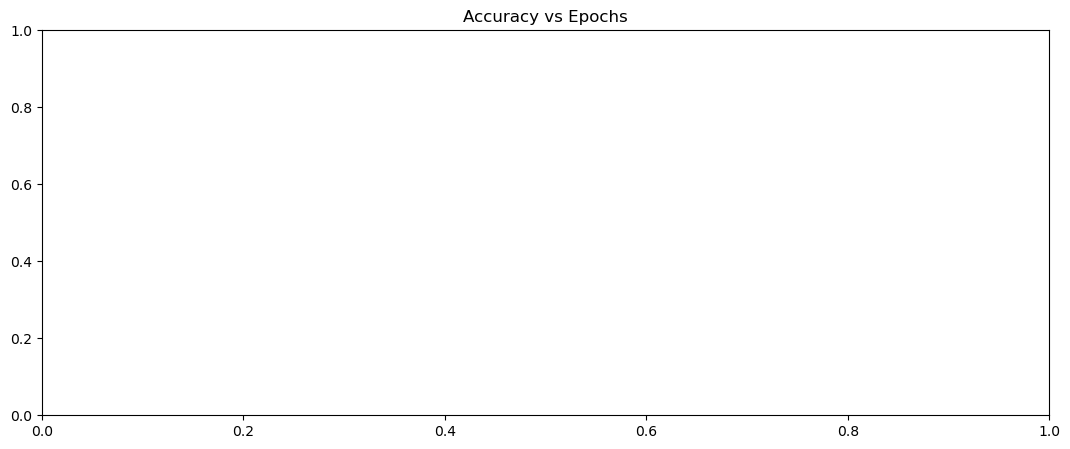

In [39]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [23]:
y_pred = model.predict(X_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

1/1 [==============================] - 1s 956ms/step


In [24]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

0.5714285714285714

In [25]:
model.save('LSTM_test.h5')

https://keras.io/examples/vision/conv_lstm/